# **Exploratory Data Analysis (EDA)**


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.ticker import PercentFormatter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from collections import Counter
from google.colab import drive
import re

drive.mount("/content/drive")
plt.rcParams["figure.dpi"] = 150

Mounted at /content/drive


In [2]:
BASE_DIR = Path("/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/")
ARTIFACTS_DIR = BASE_DIR / "artifacts"
PLOTS_DIR = BASE_DIR / "plots"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print({"artifacts": str(ARTIFACTS_DIR), "plots": str(PLOTS_DIR)})

{'artifacts': '/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts', 'plots': '/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots'}


In [3]:
train_df = pd.read_csv(ARTIFACTS_DIR / "train_clean.csv")
val_df   = pd.read_csv(ARTIFACTS_DIR / "val_clean.csv")
test_df  = pd.read_csv(ARTIFACTS_DIR / "test_clean.csv")

TEXT_COL = "text_clean" if "text_clean" in train_df.columns else "text"
print("loaded:", train_df.shape, val_df.shape, test_df.shape, "| TEXT_COL:", TEXT_COL)

loaded: (13743, 7) (1527, 7) (5626, 7) | TEXT_COL: text_clean


# **EDA**

In [4]:
# slice prevalence and length by label
TEXT_COL = "text_clean" if "text_clean" in train_df.columns else "text"

# patterns to label
neg_pat  = r"\b(?:no|not|denies|denied|without|negative for|did not|never|rule[sd]? out|free of|absence of)\b"
temp_pat = r"\b(?:after|following|soon|immediately|thereafter|subsequent|post[- ]?treatment|post[- ]?(?:op|operative)|onset|worsened|developed)\b"
drug_pat = r"\b[a-zA-Z-]*?(?:pril|sartan|statin|cillin|mycin|cycline|mab|zolam|zepam|azole|olol|dipine|caine|oxetine|pramine|prazole|afil|formin)\b"

def _slice_rate(df, pat):
    hits = df[TEXT_COL].str.contains(pat, regex=True, flags=re.IGNORECASE, na=False)
    return (
        df.assign(hit=hits)
          .groupby("label")["hit"]
          .mean()
          .reindex([0,1])
          .rename(index={0:"Not ADE",1:"ADE"})
    )

rates = pd.DataFrame({
    "Negation": _slice_rate(train_df, neg_pat),
    "Temporal": _slice_rate(train_df, temp_pat),
    "Drug-like": _slice_rate(train_df, drug_pat),
})

# length by label
lens = train_df[[TEXT_COL,"label"]].copy()
lens["len"] = lens[TEXT_COL].str.len()
bins = np.histogram_bin_edges(lens["len"], bins=50)

neg_pat — a compact list of clinical negation cues, inspired by NegEx/ConText-style triggers: “no, not, denies/denied, without, negative for, did not, never, rule(s/d) out, free of, absence of”. The \b word boundaries keep matches token-aligned; the non-capturing group (?: … ) and small variants like rule[sd]? out cover inflections without overfitting.

temp_pat — common temporality triggers that signal sequence/onset: “after, following, immediately, thereafter, subsequent, post-treatment, post-op/operative, onset, worsened, developed”. The post[- ]?… bit lets
match postop, post-op, or post operative.

drug_pat — INN/USAN stem suffixes to cheaply flag drug-like tokens (heuristic, not a full lexicon):
-pril (ACEi), -sartan (ARB), -statin, -cillin/-mycin/-cycline (antibiotics), -mab (mAbs), -zolam/-zepam (benzos), -azole (antifungals), -olol (β-blockers), -dipine (CCBs), -caine (local anesthetics), -oxetine (SSRIs), -pramine (TCAs), -prazole (PPIs), -afil (PDE5i), -formin (e.g., metformin).
The pattern \b[a-zA-Z-]*?(?:…suffixes…)\b says “any letter/hyphen string that ends with one of these stems”.

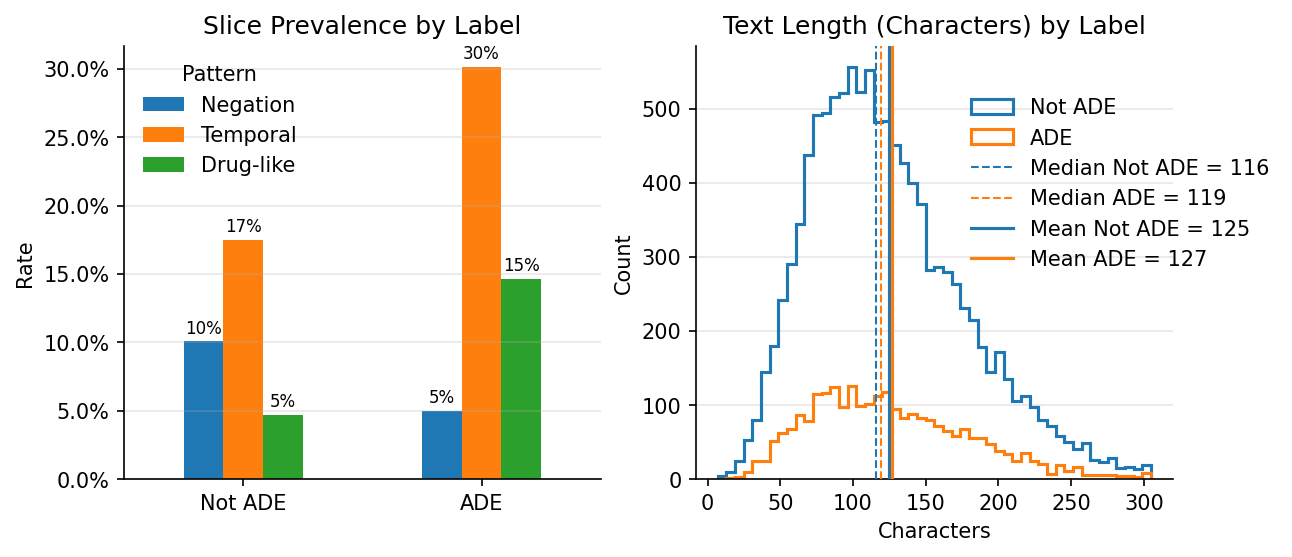

Saved to: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/edaA_slices_len_by_label.png


In [26]:
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.6), constrained_layout=True)

ax0 = axes[0]
rates.plot(kind="bar", ax=ax0, rot=0)
ax0.set_title("Slice Prevalence by Label")
ax0.set_xlabel("")
ax0.set_ylabel("Rate")
ax0.yaxis.set_major_formatter(PercentFormatter(1.0))
ax0.grid(axis="y", alpha=0.3)
ax0.legend(title="Pattern", frameon=False)
for s in ("top","right"): ax0.spines[s].set_visible(False)
for cont in ax0.containers:
    ax0.bar_label(cont, labels=[f"{h.get_height():.0%}" for h in cont], padding=2, fontsize=8)

# right: text length by label
ax1 = axes[1]
p99 = int(lens["len"].quantile(0.99)) if len(lens) else None
bins_use = bins if p99 is None else np.histogram_bin_edges(lens.loc[lens["len"] <= p99, "len"], bins=50)

for lab, name in [(0,"Not ADE"), (1,"ADE")]:
    data = lens.loc[lens.label==lab, "len"]
    if p99: data = data[data <= p99]
    ax1.hist(data, bins=bins_use, histtype="step", linewidth=1.5, label=name)

# median lines (dashed)
med0 = int(lens.loc[lens.label==0,"len"].median())
med1 = int(lens.loc[lens.label==1,"len"].median())
ax1.axvline(med0, linestyle="--", linewidth=1, color="C0", label=f"Median Not ADE = {med0}", zorder=3)
ax1.axvline(med1, linestyle="--", linewidth=1, color="C1", label=f"Median ADE = {med1}", zorder=3)

# mean lines
mean0 = int(lens.loc[lens.label==0,"len"].mean())
mean1 = int(lens.loc[lens.label==1,"len"].mean())
ax1.axvline(mean0, linestyle="-", linewidth=1.5, color="C0", label=f"Mean Not ADE = {mean0}", zorder=4)
ax1.axvline(mean1, linestyle="-", linewidth=1.5, color="C1", label=f"Mean ADE = {mean1}", zorder=4)

ax1.set_title("Text Length (Characters) by Label")
ax1.set_xlabel("Characters")
ax1.set_ylabel("Count")
ax1.grid(axis="y", alpha=0.3)
ax1.legend(frameon=False, bbox_to_anchor=(.56, 0.9), borderaxespad=0.)
for s in ("top","right"): ax1.spines[s].set_visible(False)

out_png = PLOTS_DIR / "edaA_slices_len_by_label.png"
plt.savefig(out_png, dpi=200, bbox_inches="tight")
plt.show()
print("Saved to:", out_png.resolve())



Temporal cues are more common in ADE, about 30 percent vs about 17 percent in Not-ADE.

Drug-like terms are more common in ADE, about 15 percent vs about 5 percent.

Negation is more common in Not-ADE, about 10 percent vs about 5 percent.

Length profiles are very similar across labels; means are about 125 to 127 characters and medians about 116 to 119.

A linear baseline with bigrams can use these signals; length is unlikely to confound results.

# **Top Bigrams by label**

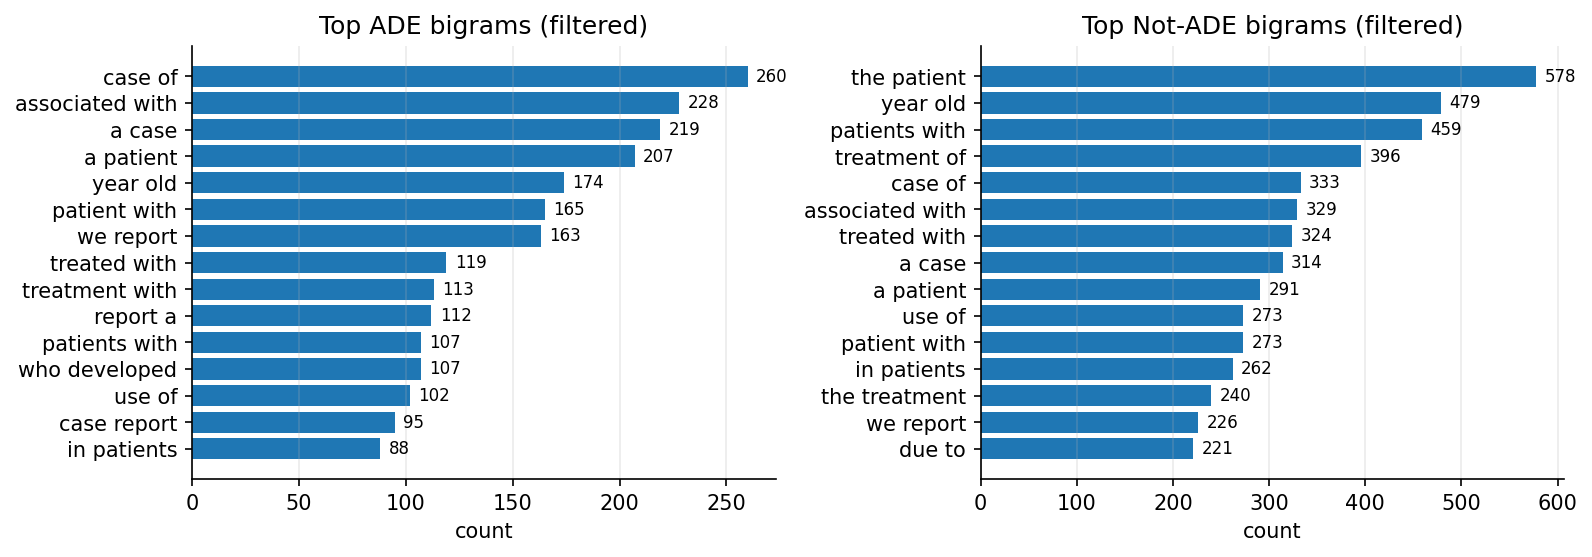

In [6]:
# **Top Bigrams by label**

STOP = set(ENGLISH_STOP_WORDS)
KEEP_PHRASES = {"due to", "secondary to", "associated with", "treated with", "caused by", "related to"}

def top_ngrams_filtered(texts, n=2, k=15, min_df=2, max_df=0.95):
    texts = texts.dropna().astype(str)
    if texts.empty: return np.array([]), np.array([])
    v = CountVectorizer(ngram_range=(n, n), min_df=min_df, max_df=max_df,
                        lowercase=True, token_pattern=r"(?u)\b\w+\b")
    X = v.fit_transform(texts)
    if X.shape[1] == 0: return np.array([]), np.array([])
    terms = np.array(v.get_feature_names_out())
    counts = np.asarray(X.sum(axis=0)).ravel()

    # drop only if BOTH words are stopwords (unless whitelisted)
    keep = []
    for t in terms:
        if t in KEEP_PHRASES:
            keep.append(True); continue
        w = t.split()
        keep.append(not (len(w)==2 and w[0] in STOP and w[1] in STOP))
    keep = np.array(keep, dtype=bool)
    terms, counts = terms[keep], counts[keep]

    idx = counts.argsort()[::-1][:k]
    return terms[idx], counts[idx]

# recompute & plot
ade_terms, ade_counts = top_ngrams_filtered(train_df.loc[train_df.label==1, TEXT_COL], n=2, k=15, min_df=2)
not_terms, not_counts = top_ngrams_filtered(train_df.loc[train_df.label==0, TEXT_COL], n=2, k=15, min_df=2)

fig, axes = plt.subplots(1, 2, figsize=(10.5, 3.6), constrained_layout=True)
def barh(ax, terms, counts, title):
    if len(terms)==0:
        ax.text(0.5,0.5,"no terms",ha="center",va="center"); ax.set_yticks([])
    else:
        ax.barh(terms[::-1], counts[::-1])
        for y,c in enumerate(counts[::-1]):
            ax.annotate(f"{int(c)}", xy=(c, y), xytext=(4,0), textcoords="offset points",
                        va="center", ha="left", fontsize=8)
    ax.set_title(title); ax.set_xlabel("count")
    ax.grid(axis="x", alpha=0.25)
    for s in ("top","right"): ax.spines[s].set_visible(False)

barh(axes[0], ade_terms, ade_counts, "Top ADE bigrams (filtered)")
barh(axes[1], not_terms, not_counts, "Top Not-ADE bigrams (filtered)")

plt.savefig(PLOTS_DIR / "edaB_top_bigrams_by_label_filtered.png", dpi=200, bbox_inches="tight")
plt.show()


ADE highlights reporting and causal phrases such as “case of,” “associated with,” “treated with,” and “who developed.”

Not-ADE includes generic report scaffolding like “the patient” and “year old,” plus shared clinical phrases.

Phrase features should help because many ADE bigrams encode sequence or causality.

## **Top unigrams by label**

/tmp/ipython-input-271046481.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


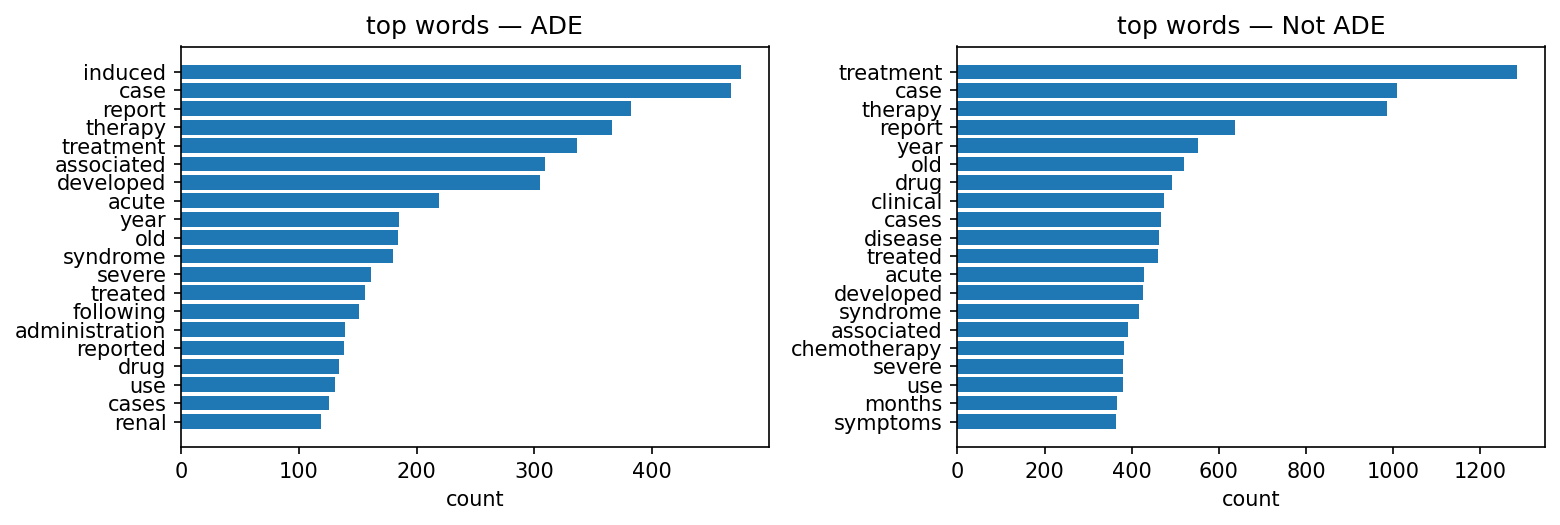

In [7]:
TEXT_COL = "text_clean" if "text_clean" in train_df.columns else "text"

EXTRA_STOPWORDS = {
    "patient","patients","mg","mcg","day","daily","days",
    "tablet","tablets","dose","doses","po","iv","bid","tid","qhs"
}
STOPWORDS = set(ENGLISH_STOP_WORDS) | EXTRA_STOPWORDS
token_re = re.compile(r"[A-Za-z']+")

def iter_tokens(series):
    for s in series:
        for w in token_re.findall(str(s).lower()):
            if w not in STOPWORDS and len(w) > 2:
                yield w

ade_counter = Counter(iter_tokens(train_df.loc[train_df.label==1, TEXT_COL]))
not_counter = Counter(iter_tokens(train_df.loc[train_df.label==0, TEXT_COL]))

TOPK = 20
ade_top = ade_counter.most_common(TOPK)
not_top = not_counter.most_common(TOPK)

# plot
fig, axes = plt.subplots(1, 2, figsize=(10.5, 3.6), constrained_layout=True)
axes[0].barh([w for w,_ in ade_top[::-1]], [c for _,c in ade_top[::-1]])
axes[0].set_title("top words — ADE"); axes[0].set_xlabel("count")
axes[1].barh([w for w,_ in not_top[::-1]], [c for _,c in not_top[::-1]])
axes[1].set_title("top words — Not ADE"); axes[1].set_xlabel("count")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "edaC_top_unigrams_by_label.png", dpi=200, bbox_inches="tight")
plt.tight_layout()

# save tables
pd.DataFrame(ade_top, columns=["token","count"]).to_csv(ARTIFACTS_DIR / "top_unigrams_ADE.csv", index=False)
pd.DataFrame(not_top, columns=["token","count"]).to_csv(ARTIFACTS_DIR / "top_unigrams_NotADE.csv", index=False)

ADE emphasizes event words such as induced, associated, developed, toxicity, and acute.

Not-ADE leans toward broader clinical context words.

Overlap is expected; uni-grams plus bi-grams with TF-IDF will separate classes better.

Domain stopwords remove dosing boilerplate and keep content words.

# **TF-IDF Δ by label**


TF-IDF = Term Frequency * Inverse Document Frequency.

TF (term frequency): how often a term appears in one document (often normalized by document length).

IDF (inverse document frequency): how rare the term is across the whole corpus.

/tmp/ipython-input-1022353726.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


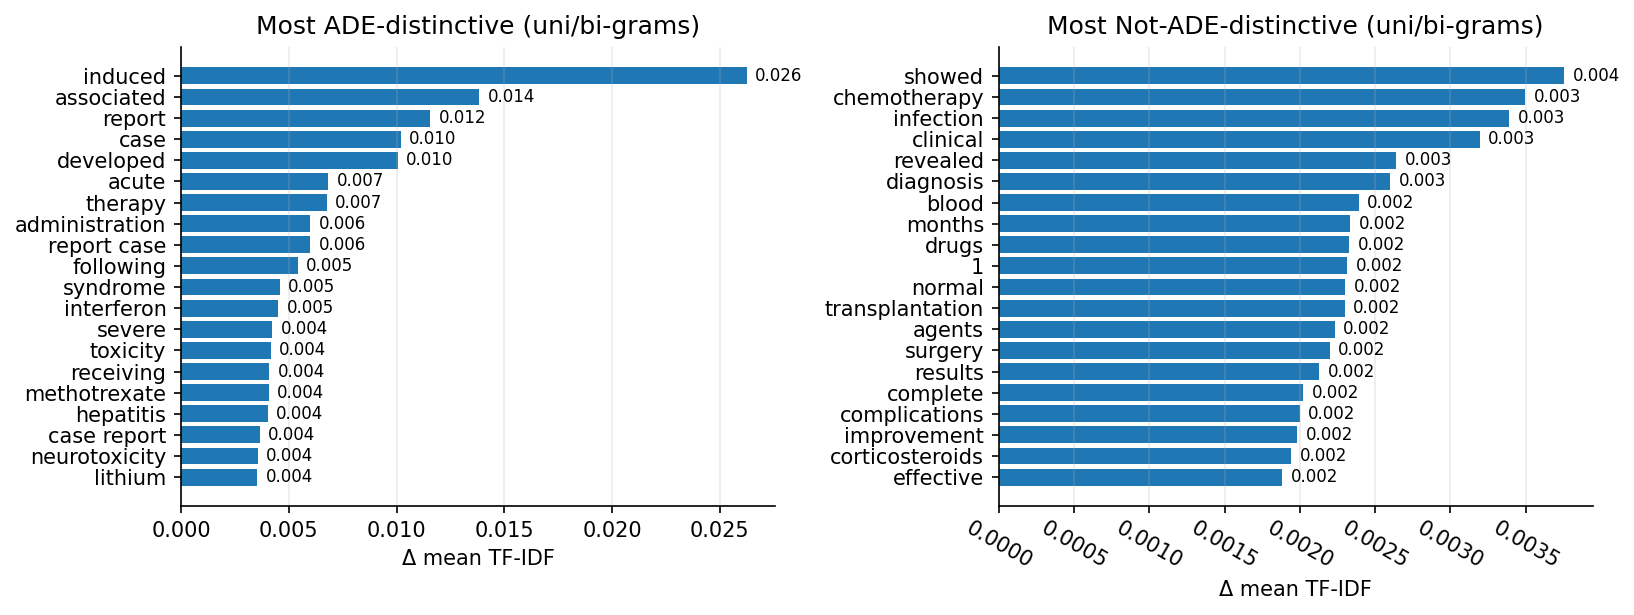

In [8]:
TEXT_COL = "text_clean" if "text_clean" in train_df.columns else "text"

EXTRA_STOPWORDS = {"patient","patients","mg","mcg","day","daily","days",
                   "tablet","tablets","dose","doses","po","iv","bid","tid","qhs"}
STOP = ENGLISH_STOP_WORDS.union(EXTRA_STOPWORDS)
STOP = sorted(list(STOP))

vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95,
    stop_words=STOP,
    lowercase=True,
    token_pattern=r"(?u)\b\w+\b",
    sublinear_tf=True
)

X = vec.fit_transform(train_df[TEXT_COL].astype(str))
y = train_df["label"].to_numpy()
vocab = vec.get_feature_names_out()

ade_mean = np.asarray(X[y==1].mean(axis=0)).ravel()
not_mean = np.asarray(X[y==0].mean(axis=0)).ravel()
delta = ade_mean - not_mean

K = 20
ade_idx = delta.argsort()[::-1][:K]
not_idx = delta.argsort()[:K]

df_ade = pd.DataFrame({"term": vocab[ade_idx], "delta": delta[ade_idx]})
df_not = pd.DataFrame({"term": vocab[not_idx], "delta": -delta[not_idx]})

fig, axes = plt.subplots(1, 2, figsize=(11, 4.2), constrained_layout=True)
def barh(ax, df, title):
    terms = df["term"].values[::-1]
    vals  = df["delta"].values[::-1]
    ax.barh(terms, vals)
    for y,v in enumerate(vals):
        ax.annotate(f"{v:.3f}", (v, y), xytext=(4,0), textcoords="offset points", va="center", fontsize=8)
    ax.set_title(title); ax.set_xlabel("Δ mean TF-IDF"); ax.grid(axis="x", alpha=0.25)
    for s in ("top","right"): ax.spines[s].set_visible(False)

barh(axes[0], df_ade, "Most ADE-distinctive (uni/bi-grams)")
barh(axes[1], df_not, "Most Not-ADE-distinctive (uni/bi-grams)")

axes[1].tick_params(axis='x', labelrotation=-30, pad=2)
for t in axes[1].get_yticklabels():
    t.set_ha('right')
    t.set_rotation_mode('anchor')

plt.tight_layout()
plt.savefig(PLOTS_DIR / "edaD_top_TF_IDF_by_label.png", dpi=200, bbox_inches="tight")
plt.tight_layout()
plt.show()


Left panel shows terms with higher mean TF-IDF in ADE, including induced, associated, report, developed, toxicity, hepatitis, and interferon. Right panel shows terms with higher mean TF-IDF in Not-ADE, including showed, chemotherapy, infection, diagnosis, surgery, transplantation, and improvement.

The absolute differences are small but consistent and align with earlier unigram and bigram views. ADE language skews toward causality and outcomes; Not-ADE skews toward general clinical context.

These results support using uni-grams and bi-grams with TF-IDF for the baselines and for model interpretation later.